In [5]:
pip install jovian
#pip install holidays

SyntaxError: invalid syntax (<ipython-input-5-5873c8e5a261>, line 1)

- Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [8]:
# module loading
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

### Load Data

- Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [3]:
# Data augmentation and normalization for training set; for validation set, we only do normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/test colab/Fish'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
class_names

['ALB', 'NoF', 'OTHER', 'YFT']

#### Visualize images

- Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


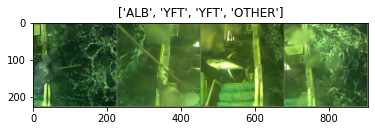

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

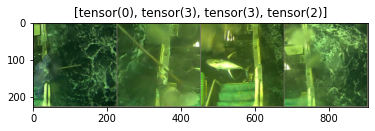

In [6]:
imshow(out, title=[x for x in classes])

### Training model

- Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    train_losses = []
    val_losses = []
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best val epoch: {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

## 1.1.1.(a) Initialize a Resnet18 model

### (1) Using the pre-trained Resnet18 model as a fixed feature extractor (only fine-tune the fully-connected layer)

- Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [12]:
model_FineTuneFC = torchvision.models.resnet18(pretrained=True)
for param in model_FineTuneFC.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_FineTuneFC_rs = model_FineTuneFC.fc.in_features

model_FineTuneFC.fc = nn.Linear(num_FineTuneFC_rs, 4) # only 4 classes

model_FineTuneFC = model_FineTuneFC.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized.
optimizer_FineTuneFC = optim.Adam(model_FineTuneFC.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_FineTuneFC = lr_scheduler.StepLR(optimizer_FineTuneFC, step_size=7, gamma=0.1)

### (2) Fine-tuning all layers of the pre-trained Resnet18 model

- Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [9]:
model_FineTuning_all = models.resnet18(pretrained=True)

num_FineTuning_all_rs = model_FineTuning_all.fc.in_features

model_FineTuning_all.fc = nn.Linear(num_FineTuning_all_rs, 4) # only 4 classes

model_FineTuning_all = model_FineTuning_all.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_FineTuning_all = optim.Adam(model_FineTuning_all.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_FineTuning_all = lr_scheduler.StepLR(optimizer_FineTuning_all, step_size=7, gamma=0.1)

### (3) Training a Resnet18 model from scratch.

- Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [10]:
model_scratch = models.resnet18(pretrained=False)

num_scratch_rs = model_scratch.fc.in_features

model_scratch.fc = nn.Linear(num_scratch_rs, 4)

model_scratch = model_scratch.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

## 1.1.1.(b) Before training, can you speculate how the training will be different between these three approaches? Which way do you think is the most appropriate given this fishing dataset, and why?

- In my opinion, I think the model that only fine-tune the fully-connected layer would have the best performance among these three approaches. The resnet18 were trained with ImageNet database containing 1,000,000+ images so each weight in each layer can accurately capture the image features. If we reset or fine-tune these weights in all layers and re-train the model by our own images, the model will decrease the ability to capture image features accurately. As a result, Fine-tuning only the fully-connected layer is the most appropriate given this fishing dataset.

## 1.1.2 Model Training/Fine-tuning

In [13]:
# Fine-tuning only the fully-connected layer
model_FineTuneFC, train_losses_FineTuneFC, val_losses_FineTuneFC = train_model(model_FineTuneFC, criterion, optimizer_FineTuneFC, exp_lr_scheduler_FineTuneFC, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.2757 Acc: 0.4205
val Loss: 1.4029 Acc: 0.4138

Epoch 1/24
----------
train Loss: 1.1749 Acc: 0.4866
val Loss: 0.8604 Acc: 0.6293

Epoch 2/24
----------
train Loss: 1.1251 Acc: 0.4994
val Loss: 0.8226 Acc: 0.6466

Epoch 3/24
----------
train Loss: 1.1103 Acc: 0.5269
val Loss: 0.8175 Acc: 0.6810

Epoch 4/24
----------
train Loss: 1.0633 Acc: 0.5471
val Loss: 0.9205 Acc: 0.6034

Epoch 5/24
----------
train Loss: 1.0760 Acc: 0.5397
val Loss: 0.8477 Acc: 0.6638

Epoch 6/24
----------
train Loss: 1.0678 Acc: 0.5477
val Loss: 0.8128 Acc: 0.6595

Epoch 7/24
----------
train Loss: 1.0100 Acc: 0.5709
val Loss: 0.7703 Acc: 0.6810

Epoch 8/24
----------
train Loss: 0.9689 Acc: 0.5856
val Loss: 0.7510 Acc: 0.7112

Epoch 9/24
----------
train Loss: 0.9985 Acc: 0.5630
val Loss: 0.7284 Acc: 0.7112

Epoch 10/24
----------
train Loss: 0.9667 Acc: 0.5972
val Loss: 0.7623 Acc: 0.7155

Epoch 11/24
----------
train Loss: 0.9982 Acc: 0.5752
val Loss: 0.7262 Acc: 0.7026

Epoch 12/24
----------
t

In [11]:
# Fine-tuning all layers
model_FineTuning_all, train_losses_FineTuning_all, val_losses_FineTuning_all = train_model(model_FineTuning_all, criterion, optimizer_FineTuning_all, exp_lr_scheduler_FineTuning_all, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.4276 Acc: 0.3380
val Loss: 1.5179 Acc: 0.3405

Epoch 1/24
----------
train Loss: 1.3324 Acc: 0.3851
val Loss: 1.2252 Acc: 0.4698

Epoch 2/24
----------
train Loss: 1.3182 Acc: 0.3839
val Loss: 1.2834 Acc: 0.3922

Epoch 3/24
----------
train Loss: 1.2772 Acc: 0.4114
val Loss: 1.1721 Acc: 0.4828

Epoch 4/24
----------
train Loss: 1.2842 Acc: 0.3851
val Loss: 1.0892 Acc: 0.4871

Epoch 5/24
----------
train Loss: 1.2719 Acc: 0.4224
val Loss: 1.3602 Acc: 0.4914

Epoch 6/24
----------
train Loss: 1.2544 Acc: 0.4279
val Loss: 1.6557 Acc: 0.4009

Epoch 7/24
----------
train Loss: 1.2315 Acc: 0.4352
val Loss: 1.0729 Acc: 0.5216

Epoch 8/24
----------
train Loss: 1.1813 Acc: 0.4713
val Loss: 1.0235 Acc: 0.5603

Epoch 9/24
----------
train Loss: 1.1493 Acc: 0.4969
val Loss: 1.0161 Acc: 0.5431

Epoch 10/24
----------
train Loss: 1.1270 Acc: 0.4969
val Loss: 1.0784 Acc: 0.5259

Epoch 11/24
----------
train Loss: 1.1431 Acc: 0.4982
val Loss: 0.9482 Acc: 0.5776

Epoch 12/24
----------
t

In [13]:
# Training a Resnet18 model from scratch
model_scratch, train_losses_scratch, val_losses_scratch = train_model(model_scratch, criterion, optimizer_scratch, exp_lr_scheduler_scratch, num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.4074 Acc: 0.3710
val Loss: 1.2385 Acc: 0.4397

Epoch 1/49
----------
train Loss: 1.3394 Acc: 0.3753
val Loss: 1.3532 Acc: 0.3276

Epoch 2/49
----------
train Loss: 1.3066 Acc: 0.3949
val Loss: 1.2850 Acc: 0.3879

Epoch 3/49
----------
train Loss: 1.2852 Acc: 0.4077
val Loss: 1.1941 Acc: 0.3879

Epoch 4/49
----------
train Loss: 1.2636 Acc: 0.4242
val Loss: 1.1005 Acc: 0.5043

Epoch 5/49
----------
train Loss: 1.2517 Acc: 0.4169
val Loss: 1.2268 Acc: 0.4095

Epoch 6/49
----------
train Loss: 1.2400 Acc: 0.4444
val Loss: 1.2241 Acc: 0.4569

Epoch 7/49
----------
train Loss: 1.2233 Acc: 0.4554
val Loss: 1.0697 Acc: 0.5129

Epoch 8/49
----------
train Loss: 1.1823 Acc: 0.4847
val Loss: 1.0497 Acc: 0.4828

Epoch 9/49
----------
train Loss: 1.1750 Acc: 0.4780
val Loss: 1.0314 Acc: 0.5129

Epoch 10/49
----------
train Loss: 1.1958 Acc: 0.4700
val Loss: 1.0201 Acc: 0.5129

Epoch 11/49
----------
train Loss: 1.1537 Acc: 0.4859
val Loss: 1.0002 Acc: 0.5431

Epoch 12/49
----------
t

- (a) For training set: I cropped a random portion of image and resize it to a given size (224x224), and then horizontally flipped the given image randomly with a given probability (p = 0.5). Finally, I normalized a tensor image with mean ([0.485, 0.456, 0.406] for each RGB channel) and standard deviation ([0.229, 0.224, 0.225] for each RGB channel).
For validation and testing set: I resized the input image to the given size (256x256), and then cropped the given image at the center with size (224x224). Finally, I normalized a tensor image with mean ([0.485, 0.456, 0.406] for each RGB channel) and standard deviation ([0.229, 0.224, 0.225] for each RGB channel).
- (b) Loss function would be cross-entropy loss; optimizer would be Adam optimizer.
- (c) For the model with training a Resnet18 model from scratch, the number of epochs is 50 (because I reset all of the weights), and the number of epochs is 25 for the other 2 models. For all models, the batch size is 4 and the learning rate is 0.001
- the learning rate is decay by a factor of 0.1 every 7 epochs

## 1.2 (a) Generate a plot of training and validation loss curves for each of the three training cases from Section 1.1.1.

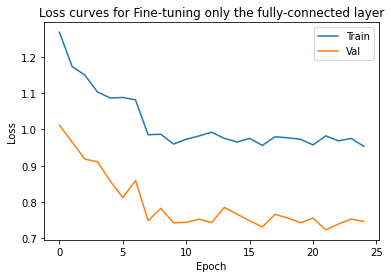

In [17]:
# plot the loss curve for Fine-tuning only the fully-connected layer
plt.plot(train_losses_FineTuneFC, label='Train')
plt.plot(val_losses_FineTuneFC, label='Val')
plt.legend()
plt.title('Loss curves for Fine-tuning only the fully-connected layer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

- Best epoch: 23; because the model has the highest accuracy in the validation set when epoch = 23

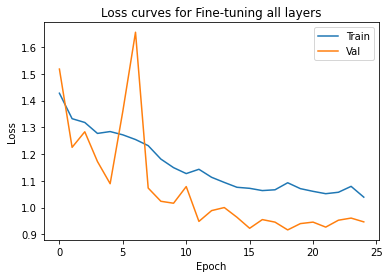

In [15]:
# plot the loss curve for Fine-tuning all layers
plt.plot(train_losses_FineTuning_all, label='Train')
plt.plot(val_losses_FineTuning_all, label='Val')
plt.legend()
plt.title('Loss curves for Fine-tuning all layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

- Best epoch: 19; because the model has the highest accuracy and the lowest loss in the validation set when epoch = 19

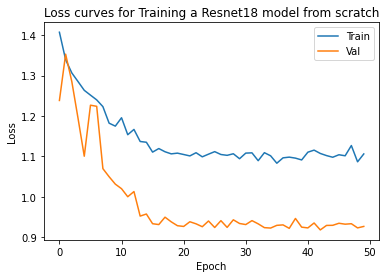

In [14]:
# plot the loss curve for Training a Resnet18 model from scratch
plt.plot(train_losses_scratch, label='Train')
plt.plot(val_losses_scratch, label='Val')
plt.legend()
plt.title('Loss curves for Training a Resnet18 model from scratch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

- Best epoch: 21; because the model has the highest accuracy in validation set when epoch = 21

## 1.2 (b) Choose a single best performing model as your final model, and report the confu- sion matrix, per-class accuracy, and weighted F1 score of this model on the validation set.

- Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [14]:
from sklearn.metrics import confusion_matrix, f1_score

correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

val_predicted = []
val_true = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_FineTuneFC(inputs)
        _, predictions = torch.max(output, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1
        for j in range(inputs.size()[0]):
            val_true.append(labels[j].cpu().numpy())
            val_predicted.append(predictions[j].cpu().numpy())

print(" ")
print("="*30)
print(" ")
# Confusion Matrix
cm = confusion_matrix(val_true, val_predicted)
ConF_MaX_plot = pd.DataFrame(cm,
                    index=['True: ALB', 'True: NoF', 'True: OTHER', 'True: YFT'],
                    columns=['Pred: ALB', 'Pred: NoF', 'Pred: OTHER', 'Pred: YFT'])
print('Confusion Matrix: ')
print(ConF_MaX_plot)

print(" ")
print("="*30)
print(" ")
# per-class accuracy
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print(" ")
print("="*30)
print(" ")
# weighted F1 score
val_weighted_F1 = f1_score(val_true, val_predicted, average='weighted')
print('Weighted F1 Score: ',val_weighted_F1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 
 
Confusion Matrix: 
             Pred: ALB  Pred: NoF  Pred: OTHER  Pred: YFT
True: ALB           57          4            9         13
True: NoF            8         37            0          1
True: OTHER          3          0           27          0
True: YFT            9          1            7         56
 
 
Accuracy for class: ALB   is 68.7 %
Accuracy for class: NoF   is 80.4 %
Accuracy for class: OTHER is 90.0 %
Accuracy for class: YFT   is 76.7 %
 
 
Weighted F1 Score:  0.7637324318041429


## 1.3 Model Performance Evaluation 

- Reference: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

In [15]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Customize ImageFolder to retrieve file name
    """
    # override the __getitem__ method.
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [16]:
test_data_dir = '/content/drive/MyDrive/test colab/Fish/test2'
image_datasets_test = ImageFolderWithPaths(root = test_data_dir, transform = data_transforms['test'])
testloader = torch.utils.data.DataLoader(image_datasets_test, batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


- Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [46]:
# Predict
test_fileName = []
test_predicted = []
with torch.no_grad():
    for data in testloader:
        inputs, labels, paths = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        paths2 = list(paths)
        for i in range(len(paths2)):
          paths2[i] = paths2[i].split("/")[-1]
        output = model_FineTuneFC(inputs)
        _, predictions = torch.max(output, 1)
        for j in range(inputs.size()[0]):
            test_predicted.append(predictions.numpy()[j])
            test_fileName.append(paths2[j])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
for i in range(len(test_predicted)):
    if test_predicted[i] == 0:
        test_predicted[i] = 'ALB'
    elif test_predicted[i] == 1:
        test_predicted[i] = 'NoF'
    elif test_predicted[i] == 2:
        test_predicted[i] = 'OTHER'
    else:
        test_predicted[i] = 'YFT'

In [53]:
df = pd.DataFrame(list(zip(test_fileName, test_predicted)))
df

,0,1
0,00nbnyg8lv.jpg,ALB
1,00w6uh7ij9.jpg,YFT
2,03id3d30l2.jpg,ALB
3,05yjz3psm1.jpg,YFT
4,06jxolt55u.jpg,ALB
...,...,...
460,znsx4xkv8w.jpg,YFT
461,zp9z3ikb5l.jpg,ALB
462,zt5hww356w.jpg,YFT
463,zv05q7bkuc.jpg,YFT


In [55]:
# save the predictions
df.to_csv('/content/drive/MyDrive/test colab/F0034WQ_CNN_predictions.csv', index=False, header = False)

# 2

## 2.1 Data Inspection

In [12]:
import re
import spacy
import jovian
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [13]:
# Load Data
train = pd.read_csv('/content/drive/MyDrive/test colab/train_yelp_reviews.csv', sep='\t', engine='python')

In [14]:
train

,text,label
0,Great time - family dinner on a Sunday night.,1
1,The classic Maine Lobster Roll was fantastic.,1
2,We won't be going back.,0
3,All I have to say is the food was amazing!!!,1
4,"Food was good, service was good, Prices were g...",1
...,...,...
895,I guess maybe we went on an off night but it w...,0
896,The restaurant atmosphere was exquisite.,1
897,"Be sure to order dessert, even if you need to ...",1
898,They could serve it with just the vinaigrette ...,1


- Reference: https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed#C18

In [15]:
# calculate sentence lengths
train['text_length'] = train['text'].apply(lambda x: len(x.split()))
train

,text,label,text_length
0,Great time - family dinner on a Sunday night.,1,9
1,The classic Maine Lobster Roll was fantastic.,1,7
2,We won't be going back.,0,5
3,All I have to say is the food was amazing!!!,1,10
4,"Food was good, service was good, Prices were g...",1,9
...,...,...,...
895,I guess maybe we went on an off night but it w...,0,13
896,The restaurant atmosphere was exquisite.,1,5
897,"Be sure to order dessert, even if you need to ...",1,23
898,They could serve it with just the vinaigrette ...,1,23


In [25]:
#mean sentence length
np.mean(train['text_length'])

10.872222222222222

- Reference: https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed#C18

In [16]:
#tokenization
import spacy
tok = spacy.load('en_core_web_sm')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

- Reference: https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed#C18

In [23]:
#count number of occurences of each word
counts = Counter()
for index, row in train.iterrows():
    counts.update(tokenize(row['text']))

### Display the most 50 commonly occurring tokens for positive review

In [18]:
positive_train = train[train['label'] == 1].copy()
positive_train

,text,label,text_length
0,Great time - family dinner on a Sunday night.,1,9
1,The classic Maine Lobster Roll was fantastic.,1,7
3,All I have to say is the food was amazing!!!,1,10
4,"Food was good, service was good, Prices were g...",1,9
5,"If you're not familiar, check it out.",1,7
...,...,...,...
893,If you love authentic Mexican food and want a ...,1,25
896,The restaurant atmosphere was exquisite.,1,5
897,"Be sure to order dessert, even if you need to ...",1,23
898,They could serve it with just the vinaigrette ...,1,23


In [19]:
counts_positive_train = Counter()
for index, row in positive_train.iterrows():
    counts_positive_train.update(tokenize(row['text']))

Top50_counts_positive = sorted(counts_positive_train.items(), key=lambda x: x[1], reverse=True)[:50]
print(Top50_counts_positive)

[('the', 279), (' ', 207), ('and', 202), ('was', 128), ('i', 122), ('a', 98), ('is', 96), ('to', 84), ('good', 66), ('this', 65), ('great', 64), ('it', 57), ('food', 53), ('place', 51), ('in', 50), ('of', 49), ('  ', 45), ('service', 43), ('very', 41), ('for', 38), ('had', 37), ('with', 36), ('you', 35), ('are', 34), ('so', 34), ('were', 32), ('have', 31), ('they', 30), ('we', 29), ('my', 29), ('on', 28), ('here', 27), ('all', 24), ('that', 23), ('friendly', 22), ('delicious', 21), ('amazing', 20), ('back', 20), ('really', 20), ('but', 20), ('best', 20), ('our', 19), ('s', 19), ('nice', 19), ('time', 18), ('t', 18), ('be', 18), ('go', 18), ('just', 17), ('as', 17)]


### Display the most 50 commonly occurring tokens for negative review

In [20]:
negative_train = train[train['label'] == 0].copy()
negative_train

,text,label,text_length
2,We won't be going back.,0,5
6,"I probably won't be back, to be honest.",0,8
8,This is a disgrace.,0,4
9,The servers are not pleasant to deal with and ...,0,16
10,The service here leaves a lot to be desired.,0,9
...,...,...,...
887,Don't do it!!!!,0,3
889,Waited and waited and waited.,0,5
891,Waited 2 hours & never got either of our pizza...,0,20
894,I'll take my business dinner dollars elsewhere.,0,7


In [21]:
counts_negative_train = Counter()
for index, row in negative_train.iterrows():
    counts_negative_train.update(tokenize(row['text']))

Top50_counts_negative = sorted(counts_negative_train.items(), key=lambda x: x[1], reverse=True)[:50]
print(Top50_counts_negative)

[('the', 247), (' ', 198), ('i', 191), ('and', 152), ('was', 138), ('to', 120), ('a', 113), ('not', 92), ('it', 83), ('t', 68), ('of', 68), ('food', 61), ('is', 59), ('for', 57), ('this', 56), ('we', 47), ('in', 47), ('  ', 42), ('that', 42), ('place', 40), ('be', 38), ('my', 37), ('at', 36), ('but', 36), ('back', 33), ('   ', 33), ('service', 32), ('with', 29), ('like', 28), ('very', 28), ('had', 28), ('so', 27), ('were', 27), ('are', 25), ('go', 25), ('there', 25), ('have', 24), ('here', 23), ('they', 22), ('you', 22), ('don', 21), ('good', 20), ('s', 20), ('our', 19), ('on', 19), ('time', 19), ('no', 19), ('will', 18), ('never', 17), ('would', 17)]


- good, great, friendly, delicious, best, and nice are words that Naive Bayes or other bag-of-word models may not be able to classify accurately. Because we also need to care about some words near our target words. For example, if there is a 'not' showing in front of 'good', then the meaning would be 'bad'. As a result, the meaning would be totally different, and Naive Bayes or other bag-of-word models are hard to detect or distinguish.

In [22]:
# Reference: https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed#C18
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 1919
num_words after: 824


In [24]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [26]:
# Reference: https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed#C18
def encode_sentence(text, vocab2index, N=20):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [27]:
train['encoded'] = train['text'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


,text,label,text_length,encoded
0,Great time - family dinner on a Sunday night.,1,9,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0, 0, 0, 0, 0..."
1,The classic Maine Lobster Roll was fantastic.,1,7,"[[11, 12, 13, 14, 15, 16, 17, 0, 0, 0, 0, 0, 0..."
2,We won't be going back.,0,5,"[[18, 19, 20, 21, 22, 23, 0, 0, 0, 0, 0, 0, 0,..."
3,All I have to say is the food was amazing!!!,1,10,"[[24, 25, 26, 27, 28, 29, 11, 30, 16, 31, 4, 0..."
4,"Food was good, service was good, Prices were g...",1,9,"[[30, 16, 32, 33, 34, 16, 32, 33, 35, 36, 32, ..."


In [28]:
#check how balanced the dataset is
Counter(train['label'])

Counter({0: 447, 1: 453})

- Pretty balanced

In [29]:
# Split data set
X = list(train['encoded'])
y = list(train['label'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## 2.2 Model Training

- First, I calculated the text length for each review. Next, I removed punctuation, numbers, and special characters, and lowercase the text. Then, en_core_web_sm in spacy package was used for tokenization. After tokenization, I used Counter() to count the number of occurences of each word, and then removed infrequent words (word count < 2).
- Before model training, I created a vocabulary to index mapping and encode our review text. The maximum length of any review is 20 words because the average length of reviews was around 10 (so I decided the maximum length be twice the average length of reviews).
- I split train_yelp_reviews into training and validation set with ratio 8:2. The first layer is the embedding layer, and its input dimension is vocabulary size = 826, and output dimsension of embedding dimension is 100. The second layer is the LSTM layer, its input is the output from the embedding layer, and the dimension of the output of LSTM is 100. For LSTM, I used bidirectional training, and the rate of dropout was 0.3. The final layer is the linear layer, and its input dimension is 100; output dimension is 2. Loss function would be cross-entropy loss; optimizer would be Adam optimizer. The epochs was 125, and learning rate was 0.01

#### Pytorch Dataset

- Reference: https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed#C18

In [30]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [31]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [42]:
# Reference: https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed#C18
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [34]:
batch_size = 64
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

### LSTM model setting

In [72]:
# Reference: https://jovian.ai/aakanksha-ns/lstm-multiclass-text-classification/v/5?utm_source=embed#C18
# Reference: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, bidirectional, n_layers) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim,
                            num_layers=n_layers, 
                            batch_first=True,
                            bidirectional=bidirectional, 
                            dropout=dropout)
        self.linear = nn.Linear(hidden_dim, 2)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [75]:
model_fixed =  LSTM_fixed_len(vocab_size, 100, 100, dropout = 0.3, bidirectional = True, n_layers = 2)

In [76]:
train_model(model_fixed, epochs=125, lr=0.01)

train loss 0.489, val loss 0.608, val accuracy 0.661, and val rmse 0.579
train loss 0.095, val loss 1.267, val accuracy 0.706, and val rmse 0.541
train loss 0.021, val loss 1.449, val accuracy 0.739, and val rmse 0.510
train loss 0.017, val loss 0.912, val accuracy 0.772, and val rmse 0.476
train loss 0.008, val loss 1.316, val accuracy 0.778, and val rmse 0.466
train loss 0.009, val loss 1.289, val accuracy 0.750, and val rmse 0.499
train loss 0.009, val loss 1.235, val accuracy 0.800, and val rmse 0.445
train loss 0.015, val loss 1.199, val accuracy 0.761, and val rmse 0.488
train loss 0.002, val loss 1.312, val accuracy 0.761, and val rmse 0.489
train loss 0.003, val loss 1.456, val accuracy 0.767, and val rmse 0.482
train loss 0.008, val loss 1.573, val accuracy 0.783, and val rmse 0.463
train loss 0.002, val loss 1.462, val accuracy 0.733, and val rmse 0.515
train loss 0.002, val loss 1.633, val accuracy 0.772, and val rmse 0.473
train loss 0.001, val loss 1.744, val accuracy 0.72

## 2.3 Evaluation

#### Load testing set

In [82]:
test = pd.read_csv('/content/drive/MyDrive/test colab/test_yelp_reviews.csv', sep='\t', engine='python')
test

,text
0,Would not recommend to others.
1,I will be back many times soon.
2,Their steaks are 100% recommended!
3,At first glance it is a lovely bakery cafe - n...
4,We waited an hour for what was a breakfast I c...
...,...
95,"The menu is always changing, food quality is g..."
96,How can you call yourself a steakhouse if you ...
97,"The food sucked, which we expected but it suck..."
98,It was a pale color instead of nice and char a...


#### Transform testing set

In [83]:
test['encoded'] = test['text'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
test['text_length'] = test['text'].apply(lambda x: len(x.split()))
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


,text,encoded,text_length
0,Would not recommend to others.,"[[289, 40, 290, 27, 691, 0, 0, 0, 0, 0, 0, 0, ...",5
1,I will be back many times soon.,"[[25, 148, 21, 23, 431, 73, 725, 0, 0, 0, 0, 0...",7
2,Their steaks are 100% recommended!,"[[243, 1020, 50, 576, 1, 0, 0, 0, 0, 0, 0, 0, ...",5
3,At first glance it is a lovely bakery cafe - n...,"[[112, 123, 1, 43, 29, 8, 814, 1201, 1808, 4, ...",15
4,We waited an hour for what was a breakfast I c...,"[[18, 1482, 77, 1166, 88, 144, 16, 8, 253, 25,...",18
...,...,...,...
95,"The menu is always changing, food quality is g...","[[11, 234, 29, 61, 1, 33, 30, 167, 29, 22, 760...",15
96,How can you call yourself a steakhouse if you ...,"[[81, 284, 38, 1, 1724, 8, 1, 37, 38, 284, 20,...",17
97,"The food sucked, which we expected but it suck...","[[11, 30, 1347, 33, 135, 18, 1612, 228, 43, 13...",15
98,It was a pale color instead of nice and char a...,"[[43, 16, 8, 1, 1887, 1, 214, 266, 48, 1, 48, ...",14


#### Prediction

In [96]:
X = list(test['encoded'])
y = list(test['text_length'])
test2 = ReviewsDataset(X, y)
test3 = DataLoader(test2, batch_size=100)
for x, y, l in test3:
    x = x.long()
    y = y.long()
    pred = model_fixed(x, l)
  
predictions = torch.max(pred, 1)[1]
predictions

tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0])

#### Save

In [98]:
Final_pred = predictions.numpy()

df_pred = pd.DataFrame(Final_pred, columns =['classification'])
df_pred

,classification
0,0
1,1
2,1
3,1
4,0
...,...
95,0
96,0
97,0
98,0


In [99]:
df_pred.to_csv('/content/drive/MyDrive/test colab/F0034WQ_LSTM_predictions.csv', index=False)